In [1]:
import matplotlib
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline  
import numpy.ma as ma
import scipy.cluster
DEFAULT_DPI = 600
matplotlib.rcParams['figure.figsize'] = (15, 8)

In [2]:
# load data
data = pd.read_csv('dataset_16_2', sep='\t', header=None)

In [3]:
pd.DataFrame(data).head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,df84cb4ecdf09e5ff08ccf605c93cd33,7eebdb49c85c7111eea1f3ca52fce8bc,1429627313,162,86401,25910,6,13,0,64,...,1,3,0,3,100,-,-,0,0,2
1,6ab6709af8922e1e9d9eac9d11646d1a,d5df093718f8f9b239376b1c136c75b1,1443635700,0,-,6971,8,10,-,0,...,-,-,-,-,-,-,-,-,-,2
2,e9f8a2dddd2445264d2db1b32e5c5c2b,f39c150ff0956f915d84e87d45f6c1e4,1443653041,0,-,1825,1,2,-,0,...,-,-,-,-,-,-,-,-,-,1
3,f3d2cb85a12f21887813cb3b22dbe7d0,6c2b4d3fbecd5f628db1090bba5bc537,1405667008,439,-,15,9,9,-,0,...,-,-,-,-,-,-,-,-,-,1
4,d6b99af7ab5d05b6c4277877f9d3af73,782094d9d0b65b59aa87456e788cd125,1430733562,150,86401,29562,13,21,0,17,...,-,0,0,-,-,-,-,0,-,1


In [4]:
val_to_num = {'-':np.nan, '':np.nan}

ncols = 55
for i in range(2, ncols):
    data[i] = [val_to_num[s] if s in val_to_num.keys() else float(s) for s in data[i]]

In [5]:
columns_to_drop = np.array([0, 49, 8]) + 2

In [6]:
data = data.drop(columns=columns_to_drop)

In [7]:
data.head()

,0,1,3,4,5,6,7,8,9,11,...,44,45,46,47,48,49,50,52,53,54
0,df84cb4ecdf09e5ff08ccf605c93cd33,7eebdb49c85c7111eea1f3ca52fce8bc,162.0,86401.0,25910.0,6.0,13.0,0.0,64.0,1.0,...,5.0,1.0,3.0,0.0,3.0,100.0,NaN,0.0,0.0,2.0
1,6ab6709af8922e1e9d9eac9d11646d1a,d5df093718f8f9b239376b1c136c75b1,0.0,NaN,6971.0,8.0,10.0,NaN,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,e9f8a2dddd2445264d2db1b32e5c5c2b,f39c150ff0956f915d84e87d45f6c1e4,0.0,NaN,1825.0,1.0,2.0,NaN,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,f3d2cb85a12f21887813cb3b22dbe7d0,6c2b4d3fbecd5f628db1090bba5bc537,439.0,NaN,15.0,9.0,9.0,NaN,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,d6b99af7ab5d05b6c4277877f9d3af73,782094d9d0b65b59aa87456e788cd125,150.0,86401.0,29562.0,13.0,21.0,0.0,17.0,1.0,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,1.0


In [8]:
def without_nans(i):
    return data[i][~np.isnan(data[i])]

### Define abnormality as rate of "how often does current object appear in the tails of distributions"

Поскольку `np.percentile` не будет работать как ожидается (мы же на самом деле хотим не хвосты распределений, а наименее часто встречающиеся значения) с мультимодальными данными (а тем более, когда наиболее часто встречающиеся значения на концах распределения, как в случае на графике ниже, например), я для каждого столбца ищу значения (корзины), которые входят в топ-2% и топ-10% наименее часто встречающихся, что соответствует 1 и 99 персентилям и 5 и 95 соответственно (если говорить о норманом распределении, где результат `percentile` совпадает с тем, что на самом деле нужно).

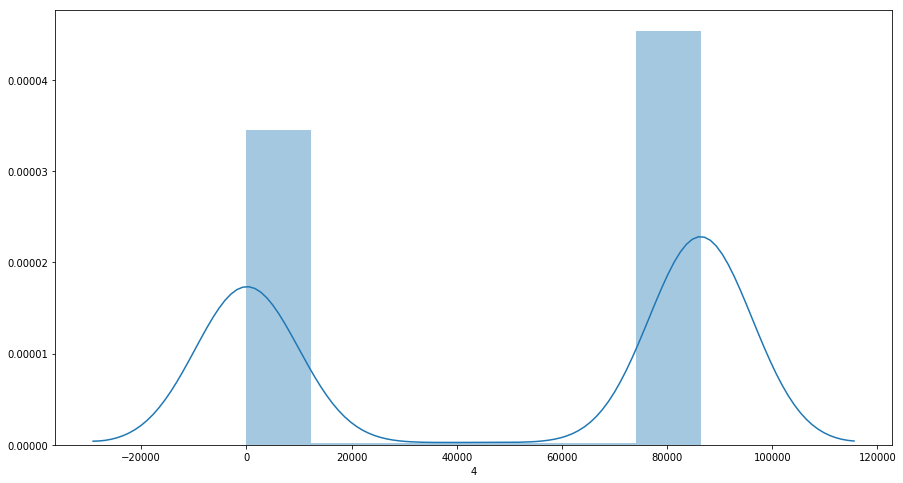

In [9]:
seaborn.distplot(without_nans(4))

In [10]:
def uncommon_values(values):
    values = values[~np.isnan(values)]
    hist = np.histogram(values, 'rice')
    idx = np.argsort(hist[0])  # bins indeces sorted by sizes
    cumsum = np.cumsum(hist[0][idx]) / len(values) 
    bins2 = cumsum < 0.02
    bins10 = cumsum < 0.1
    return np.array([hist[1][[i, i+1]] for i in idx[bins2]]), np.array([hist[1][[i, i+1]] for i in idx[bins10]])

In [11]:
np_data = np.array(data.drop(columns=[0,1]))

abnormality = {}
for i in range(np_data.shape[0]):
    abnormality[i] = 0
    
for j in range(np_data.shape[1]):
    bins2, bins10 = uncommon_values(np_data[:, j])
    for i in range(np_data.shape[0]):
        c = np_data[i][j]
        if np.isnan(c):
            continue
        # 1 point of abnormalito for getting into top or bottom 5%
        # +2 extra points of abnormality for getting into top or bottom 1%
        for bin_left_bound, bin_right_bound in bins2:
            if bin_left_bound <= c <= bin_right_bound:
                abnormality[i] += 2
                break
        for bin_left_bound, bin_right_bound in bins10:
            if bin_left_bound <= c <= bin_right_bound:
                abnormality[i] += 1
                break

#print some top abnormality examples
items = np.array(list(abnormality.items()))
idx = np.argsort(-items[:, 1])

for k, v in items[idx][:10]:
    print(k, v)
print()
    
# average abnormality 
print(np.mean(items[:, 1]), np.std(items[:, 1]))

1471 54
2836 51
97 47
8075 47
1470 46
1459 45
8821 45
5039 44
4421 44
316 43

2.14951627089 4.09746389954


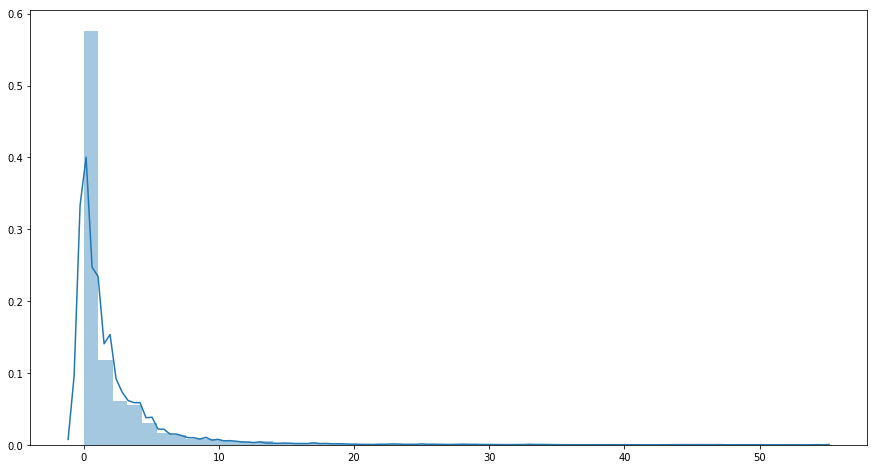

In [13]:
seaborn.distplot(items[:, 1])

### Run clusterization and check abnormality of clusters

In [26]:
without_nans = []

for i in data.columns:
    if i in [0, 1]:
        continue
    if np.isnan(data[i]).any():
        continue
    without_nans.append(i)

In [27]:
len(without_nans)

15

In [28]:
without_nans

[3, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 34, 54]

In [29]:
np_wo_nans = np.array(data[without_nans])

In [31]:
np_wo_nans.shape

(9096, 15)

In [67]:
# K-means clustering
nclusters = 8

centroid, label = scipy.cluster.vq.kmeans2(np_wo_nans, nclusters, iter=100, thresh=1e-05, minit='random', missing='warn')
# result of this k-means is unstable, changes when you recalculate the cell

# small trick, explained below
def truevar(x): 
    return np.var(x)

# put abnormality and cluster_id into DataFrame to easily calculate stats:
df_abn = pd.DataFrame(list(abnormality.values()), columns=['abn'], dtype=int)
df_label = pd.DataFrame(label, columns=['cluster_id'], dtype=int)
cluster_stats = pd.concat([df_abn, df_label], axis=1)\
.pivot_table(
    index='cluster_id',
    values='abn',
    aggfunc=[len, np.mean, np.std, truevar]
)

# reorder axis to make cluster_stats look simpler
cluster_stats2 = cluster_stats.reorder_levels([1,0], axis=1)['abn']
cluster_stats2


/usr/local/Cellar/anaconda3/lib/python3.6/site-packages/scipy/cluster/vq.py:523: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


,len,mean,std,truevar
cluster_id,,,,
0,6281,1.134851,1.813642,3.288773
2,410,5.563415,6.963202,48.367930
3,553,4.546112,6.929389,47.929610
4,283,7.106007,7.911035,62.363321
5,386,6.036269,6.869373,47.066042
6,521,3.049904,4.813983,23.129947
7,662,2.566465,3.911381,15.275794


### Calculate variance of abnormality inside clusters

In [70]:
# calculate within-cluster variance and % of total variance explained
cluster_stats2['var_in_cluster'] = cluster_stats2['truevar'] * cluster_stats2['len'] / sum(cluster_stats2['len'])
totvar = np.var(list(abnormality.values()))
cluster_stats2['var_in_cluster_%'] = cluster_stats2['var_in_cluster'] / totvar

print('')
print('total abnormality variance: %s' % totvar)
print('abnormality variance explained by between-cluster variance: %.2f%%' % ((1-sum(cluster_stats2['var_in_cluster_%'])) *100 ))
print('abnormality variance left inside clusters: %.2f%%' % (sum(cluster_stats2['var_in_cluster_%']) *100 ))

cluster_stats2



total abnormality variance: 16.789210408
abnormality variance explained by between-cluster variance: 18.17%
abnormality variance left inside clusters: 81.83%


,len,mean,std,truevar,var_in_cluster,var_in_cluster_%
cluster_id,,,,,,
0,6281,1.134851,1.813642,3.288773,2.270974,0.135264
2,410,5.563415,6.963202,48.367930,2.180173,0.129856
3,553,4.546112,6.929389,47.929610,2.913926,0.173559
4,283,7.106007,7.911035,62.363321,1.940284,0.115567
5,386,6.036269,6.869373,47.066042,1.997306,0.118964
6,521,3.049904,4.813983,23.129947,1.324835,0.078910
7,662,2.566465,3.911381,15.275794,1.111761,0.066219


Найдите переменные, которые похожи на категориальные (или могут быть интерпретированы как категориальные). Изучите распределение аномальности в кластерах, образованных значениями этих переменных.

In [12]:
possible_categoric_features = np.array([9, 10, 28, 32, 35, 36, 40]) + 2

In [72]:
np_cat_wo_nans = data[np.intersect1d(possible_categoric_features, without_nans)]

In [74]:
centroid, label = scipy.cluster.vq.kmeans2(np_cat_wo_nans, nclusters, iter=100, thresh=1e-05, minit='random', missing='warn')

df_abn = pd.DataFrame(list(abnormality.values()), columns=['abn'], dtype=int)
df_label = pd.DataFrame(label, columns=['cluster_id'], dtype=int)
cluster_stats = pd.concat([df_abn, df_label], axis=1)\
.pivot_table(
    index='cluster_id',
    values='abn',
    aggfunc=[len, np.mean, np.std, truevar]
)

cluster_stats2 = cluster_stats.reorder_levels([1,0], axis=1)['abn']
cluster_stats2

/usr/local/Cellar/anaconda3/lib/python3.6/site-packages/scipy/cluster/vq.py:523: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


,len,mean,std,truevar
cluster_id,,,,
2,8034,1.863829,3.710940,13.769359
3,41,8.536585,7.655382,57.175491
6,846,2.300236,2.538634,6.437045
7,175,13.040000,8.022497,63.992686


In [75]:
# calculate within-cluster variance and % of total variance explained
cluster_stats2['var_in_cluster'] = cluster_stats2['truevar'] * cluster_stats2['len'] / sum(cluster_stats2['len'])
totvar = np.var(list(abnormality.values()))
cluster_stats2['var_in_cluster_%'] = cluster_stats2['var_in_cluster'] / totvar

print('')
print('total abnormality variance: %s' % totvar)
print('abnormality variance explained by between-cluster variance: %.2f%%' % ((1-sum(cluster_stats2['var_in_cluster_%'])) *100 ))
print('abnormality variance left inside clusters: %.2f%%' % (sum(cluster_stats2['var_in_cluster_%']) *100 ))

cluster_stats2



total abnormality variance: 16.789210408
abnormality variance explained by between-cluster variance: 15.13%
abnormality variance left inside clusters: 84.87%


,len,mean,std,truevar,var_in_cluster,var_in_cluster_%
cluster_id,,,,,,
2,8034,1.863829,3.710940,13.769359,12.161723,0.724377
3,41,8.536585,7.655382,57.175491,0.257717,0.015350
6,846,2.300236,2.538634,6.437045,0.598696,0.035660
7,175,13.040000,8.022497,63.992686,1.231170,0.073331


Кажется, кластер 7 содержит фродовых пользователей: у него большое среднее значение abnormality и небольшая дисперсия.

In [76]:
X = np_wo_nans
y = list(abnormality.values())

In [79]:
X.shape, len(y)

((9096, 15), 9096)

In [80]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [85]:
from sklearn.metrics import mean_squared_error
print('MSE: ', mean_squared_error(y, reg.predict(X)))

MSE:  4.61191389965


In [90]:
print('Model coefs: \n', reg.coef_)

Model coefs: 
 [  1.76573123e-03   6.08672500e-05   9.36875083e-02  -1.37090632e-01
   2.79755941e-02  -8.30543385e-01   6.28582839e+00   1.36300020e-02
  -1.51869224e-02   1.03700233e-01  -3.75729833e-03   3.12075705e-03
   5.58482643e-02   1.35001375e+00   4.74741870e-01]


In [91]:
y_binary = np.array(y) >= 6

In [94]:
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestClassifier as RFC, GradientBoostingClassifier as GBC

# methods
Logit = lm.LogisticRegression(
    C=1.0, 
    class_weight=None, 
    dual=False, 
    fit_intercept=True, 
    intercept_scaling=1, 
    penalty='l2', 
    random_state=1, 
    tol=0.001
)
RF = RFC()
GBC = GBC()

In [98]:
features = np_wo_nans
labels = y_binary

N_learn = int(len(y_binary) * 0.8)
learn_features = features[:N_learn]
test_features =  features[N_learn:]
learn_labels = labels[:N_learn]
test_labels =  labels[N_learn:]

for cur_method in [Logit, RF, GBC]:

    cur_method.fit(learn_features, learn_labels)

    predict = cur_method.predict(features)

    # print 'logit score: test\t%s' % Logit.score(test_features, test_labels)
    # print 'logit score: learn\t%s' % Logit.score(learn_features, learn_labels)
    print('%s score: test\t%s' % (cur_method.__class__, cur_method.score(test_features, test_labels)))
    print('%s score: learn\t%s' % (cur_method.__class__, cur_method.score(learn_features, learn_labels)))


    print("\nDistribution of labels")
    print(np.histogram(labels,2))
    print("\nDistribution of predicted labels")
    print(np.histogram(predict,2))
    
    print()
    
    # estimate whether our fit is good or not
    print([int(p) for p in list(predict)[:20]])
    print([int(l) for l in labels[:20]])
    print(np.corrcoef(predict, labels))

    print('\nAbnormalities', np.sum(labels))
    print('Predicted abnormalities', np.sum(predict))
    print('Correct predictions for abnormalities', np.sum(predict*labels))

    prec = np.sum(predict*labels)/(np.sum(predict)+.0)
    recall = np.sum(predict*labels)/(np.sum(labels)+.0)
    print('\nPrecision of abnormality detection ', prec)
    print('Recall of abnormality detection ', recall)
    print("\nF1-measure", 2*prec*recall/(prec+recall))


    print('\nOverall stats:')
    print('Right verdicts', np.sum(predict==labels))
    print('Wrong verdicts', np.sum(predict!=labels))

    print()
    print()

<class 'sklearn.linear_model.logistic.LogisticRegression'> score: test	0.953846153846
<class 'sklearn.linear_model.logistic.LogisticRegression'> score: learn	0.949422759758

Distribution of labels
(array([8255,  841]), array([ 0. ,  0.5,  1. ]))

Distribution of predicted labels
(array([8467,  629]), array([ 0. ,  0.5,  1. ]))

[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[[ 1.          0.67441915]
 [ 0.67441915  1.        ]]

Abnormalities 841
Predicted abnormalities 629
Correct predictions for abnormalities 509

Precision of abnormality detection  0.809220985692
Recall of abnormality detection  0.605231866825

F1-measure 0.692517006803

Overall stats:
Right verdicts 8644
Wrong verdicts 452


<class 'sklearn.ensemble.forest.RandomForestClassifier'> score: test	0.960989010989
<class 'sklearn.ensemble.forest.RandomForestClassifier'> score: learn	0.996838922485

Distribution of labels
(array([8255,  841]), array